wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /teamspace/studios/this_studio/.netrc
wandb: Currently logged in as: andretiagosilva77 (andretiagosilva77-faculdade-de-engenharia-da-universidad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


🔥 Consumer Complaint Classification - Statistical Robustness Pipeline
Model: roberta-base
Learning Rate: 2e-05
Epochs: 10
Iterations: 5
💻 Using device: cuda
📊 Loading and preparing dataset...
   Original dataset size: 2023066
   Original class distribution:
product_5
Credit Reporting              1205275
Debt Collection                266842
Loans                          228599
Credit Card Services           163710
Bank Accounts and Services     158640
Name: count, dtype: int64
✅ Balanced dataset prepared: 12500 samples
📋 Classes (5): ['Bank Accounts and Services', 'Credit Card Services', 'Credit Reporting', 'Debt Collection', 'Loans']
📋 Samples per class: 2500

🔄 Starting 5 iterations for statistical robustness...
--------------------------------------------------------------------------------

📋 ITERATION 1/5
----------------------------------------
🔄 Split 1: Train=8750, Val=1875, Test=1875
   Train classes: {0: 1750, 1: 1750, 2: 1750, 3: 1750, 4: 1750}
   Val classes: {0: 375, 1: 

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚠️ No PEFT applied. Using full fine-tuning.


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



🚀 Starting training for iteration 1...


   Training with 8750 samples...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Per Class Mean,Precision Per Class Mean,Recall Per Class Mean
100,1.603300,1.600673,0.301867,0.191264,0.175914,0.301867,0.191264,0.175914,0.301867
200,1.022000,0.805509,0.734400,0.731723,0.738554,0.734400,0.731723,0.738554,0.734400
300,0.611100,0.684469,0.770133,0.768751,0.782451,0.770133,0.768751,0.782451,0.770133
400,0.637200,0.646050,0.787733,0.787251,0.805400,0.787733,0.787251,0.805400,0.787733
500,0.614900,0.599823,0.804800,0.804162,0.806916,0.804800,0.804162,0.806916,0.804800
600,0.526900,0.574437,0.813867,0.813461,0.818439,0.813867,0.813461,0.818439,0.813867
700,0.523700,0.590951,0.813867,0.813903,0.821603,0.813867,0.813903,0.821603,0.813867
800,0.477200,0.584860,0.808000,0.807889,0.809759,0.808000,0.807889,0.809759,0.808000
900,0.512600,0.584300,0.813867,0.812992,0.814722,0.813867,0.812992,0.814722,0.813867


early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled


📈 Results: Acc=0.8139, F1=0.8139


eval/accuracy,▁▇▇██████
eval/f1,▁▇▇██████
eval/f1_per_class_mean,▁▇▇██████
eval/loss,█▃▂▁▁▁▁▁▁
eval/precision,▁▇███████
eval/precision_per_class_mean,▁▇███████
eval/recall,▁▇▇██████
eval/recall_per_class_mean,▁▇▇██████
eval/runtime,▁▅▄▄▄▄▄▄█
eval/samples_per_second,█▄▅▅▅▅▅▅▁
eval/steps_per_second,█▄▅▅▅▅▅▅▁


✅ Iteration 1 completed!

📋 ITERATION 2/5
----------------------------------------
🔄 Split 2: Train=8750, Val=1875, Test=1875
   Train classes: {0: 1750, 1: 1750, 2: 1750, 3: 1750, 4: 1750}
   Val classes: {0: 375, 1: 375, 2: 375, 3: 375, 4: 375}
   Test classes: {0: 375, 1: 375, 2: 375, 3: 375, 4: 375}
🤖 Loading model: roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚠️ No PEFT applied. Using full fine-tuning.

🚀 Starting training for iteration 2...


   Training with 8750 samples...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Per Class Mean,Precision Per Class Mean,Recall Per Class Mean
100,1.610900,1.604316,0.234133,0.123320,0.088660,0.234133,0.123320,0.088660,0.234133
200,1.144300,0.765146,0.757867,0.757073,0.757939,0.757867,0.757073,0.757939,0.757867
300,0.686200,0.608481,0.790400,0.787332,0.793393,0.790400,0.787332,0.793393,0.790400
400,0.598700,0.615605,0.789867,0.791939,0.800460,0.789867,0.791939,0.800460,0.789867
500,0.602800,0.634925,0.802667,0.802490,0.805545,0.802667,0.802490,0.805545,0.802667
600,0.549500,0.645611,0.800533,0.799913,0.811433,0.800533,0.799913,0.811433,0.800533
700,0.549400,0.592283,0.798933,0.796636,0.802356,0.798933,0.796636,0.802356,0.798933
800,0.477700,0.534317,0.832533,0.831316,0.832545,0.832533,0.831316,0.832545,0.832533
900,0.478000,0.506365,0.839467,0.838588,0.839401,0.839467,0.838588,0.839401,0.839467
1000,0.431900,0.488478,0.846933,0.846068,0.846531,0.846933,0.846068,0.846531,0.846933


early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled


📈 Results: Acc=0.8363, F1=0.8360


eval/accuracy,▁▇▇▇▇▇▇██████
eval/f1,▁▇▇▇█████████
eval/f1_per_class_mean,▁▇▇▇█████████
eval/loss,█▃▂▂▂▂▂▁▁▁▁▁▁
eval/precision,▁▇███████████
eval/precision_per_class_mean,▁▇███████████
eval/recall,▁▇▇▇▇▇▇██████
eval/recall_per_class_mean,▁▇▇▇▇▇▇██████
eval/runtime,▁▅▂▃▂▆▁▅▄█▂▁▂
eval/samples_per_second,█▄▇▆▇▃█▄▅▁▇█▇
eval/steps_per_second,█▄▇▆▇▃█▄▅▁▇█▇


✅ Iteration 2 completed!

📋 ITERATION 3/5
----------------------------------------
🔄 Split 3: Train=8750, Val=1875, Test=1875
   Train classes: {0: 1750, 1: 1750, 2: 1750, 3: 1750, 4: 1750}
   Val classes: {0: 375, 1: 375, 2: 375, 3: 375, 4: 375}
   Test classes: {0: 375, 1: 375, 2: 375, 3: 375, 4: 375}
🤖 Loading model: roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚠️ No PEFT applied. Using full fine-tuning.

🚀 Starting training for iteration 3...


   Training with 8750 samples...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Per Class Mean,Precision Per Class Mean,Recall Per Class Mean
100,1.610700,1.599838,0.354667,0.274962,0.275933,0.354667,0.274962,0.275933,0.354667
200,1.045700,0.744238,0.774933,0.773966,0.787479,0.774933,0.773966,0.787479,0.774933
300,0.673700,0.583061,0.815467,0.815947,0.819200,0.815467,0.815947,0.819200,0.815467
400,0.566100,0.578454,0.813333,0.812516,0.820630,0.813333,0.812516,0.820630,0.813333
500,0.610100,0.529899,0.829867,0.830069,0.831553,0.829867,0.830069,0.831553,0.829867
600,0.558200,0.611057,0.796800,0.800661,0.825582,0.796800,0.800661,0.825582,0.796800
700,0.513300,0.585111,0.816000,0.816471,0.829629,0.816000,0.816471,0.829629,0.816000
800,0.476900,0.503373,0.838933,0.839376,0.846144,0.838933,0.839376,0.846144,0.838933
900,0.493700,0.495821,0.836800,0.836154,0.839482,0.836800,0.836154,0.839482,0.836800
1000,0.479000,0.489456,0.842667,0.843322,0.850117,0.842667,0.843322,0.850117,0.842667


early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled


📈 Results: Acc=0.8379, F1=0.8380


eval/accuracy,▁▇▇▇█▇▇███████████
eval/f1,▁▇▇▇█▇▇███████████
eval/f1_per_class_mean,▁▇▇▇█▇▇███████████
eval/loss,█▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▂
eval/precision,▁▇▇▇██████████████
eval/precision_per_class_mean,▁▇▇▇██████████████
eval/recall,▁▇▇▇█▇▇███████████
eval/recall_per_class_mean,▁▇▇▇█▇▇███████████
eval/runtime,▄█▆▅▄▅▆█▇▆█▃▅▁▄▆▇█
eval/samples_per_second,▅▁▃▄▅▄▃▁▂▃▁▆▄█▅▃▂▁
eval/steps_per_second,▅▁▃▄▅▄▃▁▂▃▁▆▄█▅▃▂▁


✅ Iteration 3 completed!

📋 ITERATION 4/5
----------------------------------------
🔄 Split 4: Train=8750, Val=1875, Test=1875
   Train classes: {0: 1750, 1: 1750, 2: 1750, 3: 1750, 4: 1750}
   Val classes: {0: 375, 1: 375, 2: 375, 3: 375, 4: 375}
   Test classes: {0: 375, 1: 375, 2: 375, 3: 375, 4: 375}
🤖 Loading model: roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚠️ No PEFT applied. Using full fine-tuning.

🚀 Starting training for iteration 4...


   Training with 8750 samples...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Per Class Mean,Precision Per Class Mean,Recall Per Class Mean
100,1.608500,1.604973,0.200000,0.066667,0.040000,0.200000,0.066667,0.040000,0.200000
200,1.091500,0.742083,0.773333,0.770940,0.781384,0.773333,0.770940,0.781384,0.773333
300,0.659500,0.582330,0.818133,0.817767,0.823613,0.818133,0.817767,0.823613,0.818133
400,0.596500,0.562984,0.819200,0.818109,0.821443,0.819200,0.818109,0.821443,0.819200
500,0.633800,0.547248,0.816533,0.817509,0.829306,0.816533,0.817509,0.829306,0.816533
600,0.510100,0.515324,0.828800,0.828536,0.833139,0.828800,0.828536,0.833139,0.828800
700,0.480400,0.545461,0.819733,0.818189,0.835428,0.819733,0.818189,0.835428,0.819733
800,0.506200,0.510966,0.838400,0.838234,0.840560,0.838400,0.838234,0.840560,0.838400
900,0.550200,0.489683,0.843200,0.842800,0.845780,0.843200,0.842800,0.845780,0.843200
1000,0.442700,0.505838,0.845867,0.845732,0.847118,0.845867,0.845732,0.847118,0.845867


early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled


📈 Results: Acc=0.8341, F1=0.8322


eval/accuracy,▁▇█████████████████
eval/f1,▁▇█████████████████
eval/f1_per_class_mean,▁▇█████████████████
eval/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▇█████████████████
eval/precision_per_class_mean,▁▇█████████████████
eval/recall,▁▇█████████████████
eval/recall_per_class_mean,▁▇█████████████████
eval/runtime,▂▂▂▁█▂▂▂▂▂▂▁▂▂▂▂▃▁▂
eval/samples_per_second,▇▇▇█▁▇▇▇▇▇▇█▇▇▇▇▆█▇
eval/steps_per_second,▇▇▇█▁▇▇▇▇▇▇█▇▇▇▇▆█▇


✅ Iteration 4 completed!

📋 ITERATION 5/5
----------------------------------------
🔄 Split 5: Train=8750, Val=1875, Test=1875
   Train classes: {0: 1750, 1: 1750, 2: 1750, 3: 1750, 4: 1750}
   Val classes: {0: 375, 1: 375, 2: 375, 3: 375, 4: 375}
   Test classes: {0: 375, 1: 375, 2: 375, 3: 375, 4: 375}
🤖 Loading model: roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚠️ No PEFT applied. Using full fine-tuning.

🚀 Starting training for iteration 5...


   Training with 8750 samples...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,F1 Per Class Mean,Precision Per Class Mean,Recall Per Class Mean
100,1.607400,1.604966,0.241067,0.137303,0.185456,0.241067,0.137303,0.185456,0.241067
200,1.225700,0.931055,0.686933,0.667430,0.716958,0.686933,0.667430,0.716958,0.686933
300,0.717800,0.600101,0.803733,0.804715,0.813352,0.803733,0.804715,0.813352,0.803733
400,0.733800,0.565636,0.812267,0.813256,0.816942,0.812267,0.813256,0.816942,0.812267
500,0.643100,0.560594,0.819200,0.819499,0.822331,0.819200,0.819499,0.822331,0.819200
600,0.552700,0.526040,0.825067,0.825309,0.831481,0.825067,0.825309,0.831481,0.825067
700,0.535100,0.506030,0.827733,0.827951,0.834371,0.827733,0.827951,0.834371,0.827733
800,0.502000,0.507046,0.833067,0.831665,0.836633,0.833067,0.831665,0.836633,0.833067
900,0.514400,0.543624,0.828267,0.829695,0.837847,0.828267,0.829695,0.837847,0.828267
1000,0.541200,0.497935,0.829333,0.829647,0.835398,0.829333,0.829647,0.835398,0.829333


early stopping required metric_for_best_model, but did not find eval_accuracy so early stopping is disabled


📈 Results: Acc=0.8507, F1=0.8507


eval/accuracy,▁▆▇████████████
eval/f1,▁▆█████████████
eval/f1_per_class_mean,▁▆█████████████
eval/loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▇█████████████
eval/precision_per_class_mean,▁▇█████████████
eval/recall,▁▆▇████████████
eval/recall_per_class_mean,▁▆▇████████████
eval/runtime,▁▆▂▃▅▆▃▃█▆▆▇▇▅▅
eval/samples_per_second,█▃▇▆▄▃▆▆▁▂▃▂▂▄▄
eval/steps_per_second,█▃▇▆▄▃▆▆▁▃▃▂▂▄▄


✅ Iteration 5 completed!

📊 FINAL STATISTICAL ROBUSTNESS ANALYSIS

📈 AGGREGATED METRICS ACROSS 5 ITERATIONS:
------------------------------------------------------------
Accuracy    : 0.8346 ± 0.0118 [0.8139 - 0.8507]
F1          : 0.8342 ± 0.0119 [0.8139 - 0.8507]
Precision   : 0.8366 ± 0.0110 [0.8184 - 0.8528]
Recall      : 0.8346 ± 0.0118 [0.8139 - 0.8507]

📊 INDIVIDUAL ITERATION RESULTS:
------------------------------------------------------------
Iteration  1: Acc=0.8139, F1=0.8139, Prec=0.8184, Rec=0.8139
Iteration  2: Acc=0.8363, F1=0.8360, Prec=0.8360, Rec=0.8363
Iteration  3: Acc=0.8379, F1=0.8380, Prec=0.8395, Rec=0.8379
Iteration  4: Acc=0.8341, F1=0.8322, Prec=0.8361, Rec=0.8341
Iteration  5: Acc=0.8507, F1=0.8507, Prec=0.8528, Rec=0.8507


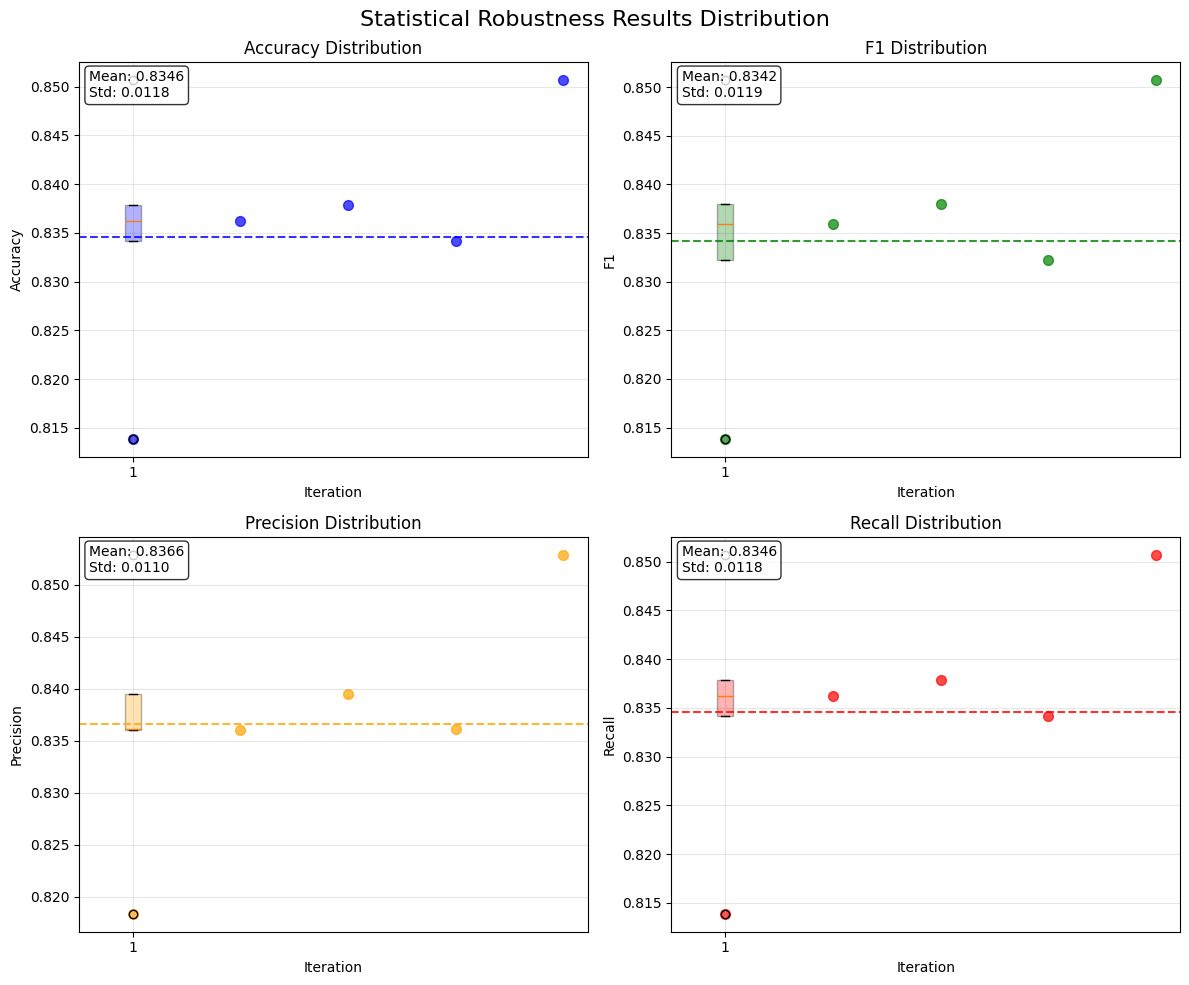


✅ Pipeline completed successfully!
📁 Results saved in: ./outputs
📈 Check Weights & Biases project: consumer-complaints-robustness
📊 Visualizations saved as: ./outputs/results_distribution.png

⚖️  CONCLUSION: Model shows MODERATE statistical robustness


In [1]:
## Consumer Complaint Classification Pipeline

import os
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize 
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer,
    EarlyStoppingCallback
)
from peft import get_peft_model, LoraModel ,LoraConfig, TaskType, PrefixEncoder, PrefixTuningConfig, IA3Config, IA3Model
from torch.utils.data import Dataset
import wandb
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# =====================================
# W&B AUTHENTICATION
# =====================================

# Insert your W&B API key here
WANDB_API_KEY = "71205bbb0d873d20bc29f836d86ca04ce650833e"  # Replace with your actual API key

# Login to W&B
wandb.login(key=WANDB_API_KEY)

# =====================================
# CONFIGURATION & SETUP
# =====================================

class Config:
    # Model Configuration - Choose appropriate pre-trained model
    MODEL_NAME = "roberta-base"  # Efficient for English text classification
    MAX_LENGTH = 512
    
    # Training Configuration (Fixed hyperparameters - no tuning)
    LEARNING_RATE = 2e-5  # Lower learning rate as suggested by professor
    BATCH_SIZE = 16
    NUM_EPOCHS = 10  # More epochs to observe learning curves and plateaus
    WARMUP_STEPS = 500
    WEIGHT_DECAY = 0.01
    
    # Statistical Robustness Configuration
    NUM_ITERATIONS = 5  # Different train/val/test splits
    SAMPLE_SIZE_PER_CLASS = 2500  # Balanced sampling per class
    
    # Monitoring & Logging
    LOGGING_STEPS = 50  # Frequent logging for real-time metrics
    EVAL_STEPS = 100    # Evaluate every 100 steps
    SAVE_STEPS = 200
    
    # Paths
    DATA_PATH = './data/complaints.csv'  # make sure the file exists here
    OUTPUT_DIR = './outputs'  # local directory you can write to
    
    # W&B Configuration
    WANDB_PROJECT = "consumer-complaints-robustness"
    WANDB_ENTITY = None  # Set your W&B username if needed

def set_seed(seed=42):
    """Set seed for reproducibility across all iterations"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
def setup_wandb(iteration):
    """Initialize W&B for tracking real-time metrics"""
    wandb.init(
        project=Config.WANDB_PROJECT,
        entity=Config.WANDB_ENTITY,
        name=f"iteration_{iteration + 1}",
        config={
            "model": Config.MODEL_NAME,
            "learning_rate": Config.LEARNING_RATE,
            "batch_size": Config.BATCH_SIZE,
            "epochs": Config.NUM_EPOCHS,
            "max_length": Config.MAX_LENGTH,
            "iteration": iteration + 1,
            "sample_size_per_class": Config.SAMPLE_SIZE_PER_CLASS
        },
        reinit=True,
        tags=["statistical_robustness", "transformer", "classification"]
    )

# =====================================
# DATASET PREPARATION
# =====================================

class ComplaintDataset(Dataset):
    """Custom dataset for consumer complaints"""
    
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

def load_and_prepare_data():
    """Load and prepare the consumer complaints dataset"""
    print("📊 Loading and preparing dataset...")
    
    # Load data
    df = pd.read_csv(Config.DATA_PATH)
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    print(f"   Original dataset size: {len(df)}")
    print(f"   Original class distribution:")
    print(df['product_5'].value_counts())
    
    # Balance dataset by sampling from each class
    df_balanced = df.groupby("product_5").sample(
        n=Config.SAMPLE_SIZE_PER_CLASS, 
        random_state=42,
        replace=False  # Ensure no duplicates
    ).reset_index(drop=True)
    
    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(df_balanced['product_5'])
    
    # Create label mapping
    label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
    
    print(f"✅ Balanced dataset prepared: {len(df_balanced)} samples")
    print(f"📋 Classes ({len(label_mapping)}): {list(label_mapping.values())}")
    print(f"📋 Samples per class: {Config.SAMPLE_SIZE_PER_CLASS}")
    
    return df_balanced['narrative'].values, encoded_labels, label_mapping, label_encoder

def create_stratified_splits(texts, labels, iteration):
    """Create stratified train/validation/test splits for statistical robustness"""
    
    # Use different random state for each iteration to ensure different splits
    random_state = 42 + iteration * 10
    
    # First split: 70% train, 30% temp
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        texts, labels, 
        test_size=0.3, 
        random_state=random_state, 
        stratify=labels
    )
    
    # Second split: 15% validation, 15% test (from the 30% temp)
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels,
        test_size=0.5,  # 50% of 30% = 15% of total
        random_state=random_state,
        stratify=temp_labels
    )
    
    print(f"🔄 Split {iteration + 1}: Train={len(train_texts)}, Val={len(val_texts)}, Test={len(test_texts)}")
    
    # Verify class distribution is maintained
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    unique_val, counts_val = np.unique(val_labels, return_counts=True)
    unique_test, counts_test = np.unique(test_labels, return_counts=True)
    
    print(f"   Train classes: {dict(zip(unique_train, counts_train))}")
    print(f"   Val classes: {dict(zip(unique_val, counts_val))}")
    print(f"   Test classes: {dict(zip(unique_test, counts_test))}")
    
    return (train_texts, train_labels), (val_texts, val_labels), (test_texts, test_labels)

# =====================================
# MODEL & TRAINING SETUP
# =====================================

def setup_model_and_tokenizer(num_labels, model_type="distilbert", peft_type="none"):
    """Initialize model, tokenizer, and wrap with PEFT if specified"""
    print(f"🤖 Loading model: {Config.MODEL_NAME}")
    
    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(
        Config.MODEL_NAME,
        num_labels=num_labels,
        problem_type="single_label_classification"
    )
    
    # Add pad token if missing
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = model.config.eos_token_id

    # Determine target modules for PEFT
    if peft_type.lower() == "lora":
        if model_type == "distilbert":
            target_modules = ["q_lin", "v_lin"]
        elif model_type == "roberta":
            target_modules = ["q", "v"]
        else:
            raise ValueError(f"Unsupported model_type for LoRA: {model_type}")

        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=16,
            target_modules=target_modules,
            lora_dropout=0.1,
            bias="none"
        )
        model = get_peft_model(model, lora_config)

    elif peft_type.lower() == "prefix":
        prefix_config = PrefixTuningConfig(
            peft_type="PREFIX_TUNING",
            task_type="SEQ_CLS",
            num_virtual_tokens=20,
            token_dim=model.config.hidden_size,
            num_attention_heads=model.config.num_attention_heads,
            num_layers=model.config.num_hidden_layers,
        )
        model = get_peft_model(model, prefix_config)

    elif peft_type.lower() == "ia3":
        ia3_config = IA3Config(
            peft_type="IA3",
            task_type="SEQ_CLS",
            target_modules=["k", "v"],
            feedforward_modules=["intermediate.dense"]
        )
        model = get_peft_model(model, ia3_config)

    else:
        print("⚠️ No PEFT applied. Using full fine-tuning.")

    return model, tokenizer

def compute_metrics(eval_pred):
    """Compute comprehensive metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )
    accuracy = accuracy_score(labels, predictions)
    
    # Per-class metrics for detailed analysis
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        labels, predictions, average=None, zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'f1_per_class_mean': np.mean(f1_per_class),
        'precision_per_class_mean': np.mean(precision_per_class),
        'recall_per_class_mean': np.mean(recall_per_class)
    }

# =====================================
# TRAINING PIPELINE
# =====================================

def train_single_iteration(iteration, train_data, val_data, test_data, 
                         model, tokenizer, label_mapping):
    """Train model for a single iteration and evaluate performance"""
    
    print(f"\n🚀 Starting training for iteration {iteration + 1}...")
    
    # Initialize W&B for this iteration
    setup_wandb(iteration)
    
    # Create datasets from data tuples
    train_dataset = ComplaintDataset(*train_data, tokenizer, Config.MAX_LENGTH)
    val_dataset = ComplaintDataset(*val_data, tokenizer, Config.MAX_LENGTH)
    test_dataset = ComplaintDataset(*test_data, tokenizer, Config.MAX_LENGTH)
    
    # Define iteration-specific paths
    iter_dir = f"{Config.OUTPUT_DIR}/iteration_{iteration + 1}"
    
    # Setup training arguments with aligned evaluation and saving strategies
    training_args = TrainingArguments(
        # Basic configuration
        output_dir=iter_dir,
        num_train_epochs=Config.NUM_EPOCHS,
        per_device_train_batch_size=Config.BATCH_SIZE,
        per_device_eval_batch_size=Config.BATCH_SIZE,
        
        # Optimization parameters
        learning_rate=Config.LEARNING_RATE,
        weight_decay=Config.WEIGHT_DECAY,
        warmup_steps=Config.WARMUP_STEPS,
        
        # Evaluation and saving - MUST use the same strategy when using load_best_model_at_end
        eval_strategy="steps",  # Changed from "no" to "steps"
        save_strategy="steps",
        eval_steps=Config.EVAL_STEPS,
        save_steps=Config.SAVE_STEPS,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        greater_is_better=True,
        save_total_limit=3,
        
        # Logging
        logging_dir=f"{iter_dir}/logs",
        logging_steps=Config.LOGGING_STEPS,
        logging_first_step=True,
        report_to="wandb",
        run_name=f"iteration_{iteration + 1}",
        
        # System settings
        dataloader_num_workers=0,
        fp16=torch.cuda.is_available(),
        seed=42 + iteration,
    )
    
    # Initialize trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)]
    )
    
    # Train and evaluate
    print(f"   Training with {len(train_dataset)} samples...")
    train_result = trainer.train()
    test_results = trainer.evaluate(test_dataset, metric_key_prefix="test")
    
    # Log training metrics to W&B
    wandb.log({
        "train_runtime": train_result.metrics.get("train_runtime", 0),
        "train_samples_per_second": train_result.metrics.get("train_samples_per_second", 0),
        "total_train_steps": train_result.global_step,
        "iteration": iteration + 1
    })
    
    # Generate predictions and classification report
    predictions = trainer.predict(test_dataset)
    # Get raw predicted probabilities (after softmax)
    probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

    # True labels
    y_true = label_binarize(test_data[1], classes=list(range(len(label_mapping))))

    # Compute ROC AUC for each class
    roc_auc_per_class = {}
    for i, class_name in enumerate(label_mapping.values()):
        fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
        auc_score = roc_auc_score(y_true[:, i], probs[:, i])
        roc_auc_per_class[class_name] = auc_score

    # Optional: Plot and log ROC curve to W&B
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {class_name}')
        plt.legend(loc='lower right')
        plt.grid()
        roc_path = f"{iter_dir}/roc_{class_name}.png"
        plt.savefig(roc_path)
        wandb.log({f"roc_curve_{class_name}": wandb.Image(roc_path)})
        plt.close()
    y_pred = np.argmax(predictions.predictions, axis=1)
    class_names = [label_mapping[i] for i in range(len(label_mapping))]
    report = classification_report(
        test_data[1], y_pred, target_names=class_names, output_dict=True, zero_division=0
    )
    
    # Log test results
    wandb.log({
        "test_accuracy": test_results["test_accuracy"],
        "test_f1": test_results["test_f1"],
        "test_precision": test_results["test_precision"],
        "test_recall": test_results["test_recall"]
    })
    
    # Log per-class metrics
    for i, class_name in enumerate(class_names):
        if str(i) in report:
            class_key = class_name.lower().replace(' ', '_')
            wandb.log({
                f"test_{class_key}_f1": report[str(i)]['f1-score'],
                f"test_{class_key}_precision": report[str(i)]['precision'],
                f"test_{class_key}_recall": report[str(i)]['recall']
            })
    
    # Print results
    print(f"📈 Results: Acc={test_results['test_accuracy']:.4f}, F1={test_results['test_f1']:.4f}")
    
    # Save model and tokenizer
    model_path = f"{Config.OUTPUT_DIR}/best_model_iteration_{iteration + 1}"
    trainer.save_model(model_path)
    tokenizer.save_pretrained(model_path)
    
    wandb.finish()
    
    # Return key metrics
    return {
        'accuracy': test_results["test_accuracy"],
        'f1': test_results["test_f1"],
        'precision': test_results["test_precision"],
        'recall': test_results["test_recall"],
        'classification_report': report,
        'train_steps': train_result.global_step,
        'model_path': model_path
    }

# =====================================
# MAIN PIPELINE EXECUTION
# =====================================

def create_results_summary(all_results):
    """Create comprehensive results summary"""
    
    # Extract metrics
    accuracies = [r['accuracy'] for r in all_results]
    f1_scores = [r['f1'] for r in all_results]
    precisions = [r['precision'] for r in all_results]
    recalls = [r['recall'] for r in all_results]
    
    # Calculate statistics
    results_summary = {
        'accuracy': {
            'mean': np.mean(accuracies),
            'std': np.std(accuracies),
            'min': np.min(accuracies),
            'max': np.max(accuracies),
            'values': accuracies
        },
        'f1': {
            'mean': np.mean(f1_scores),
            'std': np.std(f1_scores),
            'min': np.min(f1_scores),
            'max': np.max(f1_scores),
            'values': f1_scores
        },
        'precision': {
            'mean': np.mean(precisions),
            'std': np.std(precisions),
            'min': np.min(precisions),
            'max': np.max(precisions),
            'values': precisions
        },
        'recall': {
            'mean': np.mean(recalls),
            'std': np.std(recalls),
            'min': np.min(recalls),
            'max': np.max(recalls),
            'values': recalls
        }
    }
    
    return results_summary

def plot_results_distribution(results_summary):
    """Create visualization of results distribution"""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Statistical Robustness Results Distribution', fontsize=16)
    
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    colors = ['blue', 'green', 'orange', 'red']
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        ax = axes[i//2, i%2]
        values = results_summary[metric]['values']
        
        # Box plot
        ax.boxplot(values, patch_artist=True, 
                  boxprops=dict(facecolor=color, alpha=0.3))
        ax.scatter(range(1, len(values)+1), values, 
                  color=color, alpha=0.7, s=50)
        
        # Add mean line
        mean_val = results_summary[metric]['mean']
        ax.axhline(y=mean_val, color=color, linestyle='--', alpha=0.8)
        
        ax.set_title(f'{metric.capitalize()} Distribution')
        ax.set_ylabel(metric.capitalize())
        ax.set_xlabel('Iteration')
        ax.grid(True, alpha=0.3)
        
        # Add statistics text
        std_val = results_summary[metric]['std']
        ax.text(0.02, 0.98, f'Mean: {mean_val:.4f}\nStd: {std_val:.4f}', 
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'{Config.OUTPUT_DIR}/results_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """Main pipeline execution with comprehensive statistical robustness analysis"""
    
    print("🔥 Consumer Complaint Classification - Statistical Robustness Pipeline")
    print("=" * 80)
    print(f"Model: {Config.MODEL_NAME}")
    print(f"Learning Rate: {Config.LEARNING_RATE}")
    print(f"Epochs: {Config.NUM_EPOCHS}")
    print(f"Iterations: {Config.NUM_ITERATIONS}")
    print("=" * 80)
    
    # Set up environment
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"💻 Using device: {device}")
    
    # Create output directory
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    
    # Load and prepare data
    texts, labels, label_mapping, label_encoder = load_and_prepare_data()
    
    # Store results across iterations
    all_results = []
    
    print(f"\n🔄 Starting {Config.NUM_ITERATIONS} iterations for statistical robustness...")
    print("-" * 80)
    
    # Run multiple iterations with different splits
    for iteration in range(Config.NUM_ITERATIONS):
        print(f"\n📋 ITERATION {iteration + 1}/{Config.NUM_ITERATIONS}")
        print("-" * 40)
        
        # Create new splits for this iteration
        train_data, val_data, test_data = create_stratified_splits(texts, labels, iteration)
        
        # Initialize fresh model for each iteration
        model, tokenizer = setup_model_and_tokenizer(len(label_mapping), "roberta")
        model.to(device)
        
        # Train and evaluate
        results = train_single_iteration(
            iteration, train_data, val_data, test_data, 
            model, tokenizer, label_mapping
        )
        
        all_results.append(results)
        print(f"✅ Iteration {iteration + 1} completed!")
        
        # Clear CUDA cache to prevent memory issues
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # =====================================
    # AGGREGATE RESULTS & ANALYSIS
    # =====================================
    
    print("\n" + "=" * 80)
    print("📊 FINAL STATISTICAL ROBUSTNESS ANALYSIS")
    print("=" * 80)
    
    # Create comprehensive results summary
    results_summary = create_results_summary(all_results)
    
    # Print aggregated statistics
    print(f"\n📈 AGGREGATED METRICS ACROSS {Config.NUM_ITERATIONS} ITERATIONS:")
    print("-" * 60)
    for metric in ['accuracy', 'f1', 'precision', 'recall']:
        stats = results_summary[metric]
        print(f"{metric.capitalize():12}: {stats['mean']:.4f} ± {stats['std']:.4f} "
              f"[{stats['min']:.4f} - {stats['max']:.4f}]")
    
    print(f"\n📊 INDIVIDUAL ITERATION RESULTS:")
    print("-" * 60)
    for i, results in enumerate(all_results):
        print(f"Iteration {i+1:2d}: Acc={results['accuracy']:.4f}, "
              f"F1={results['f1']:.4f}, Prec={results['precision']:.4f}, "
              f"Rec={results['recall']:.4f}")
    
    # Create visualization
    plot_results_distribution(results_summary)
    
    # Save detailed results
    results_df = pd.DataFrame([
        {
            'iteration': i+1,
            'accuracy': r['accuracy'],
            'f1': r['f1'],
            'precision': r['precision'],
            'recall': r['recall'],
            'train_steps': r['train_steps'],
            'model_path': r['model_path']
        }
        for i, r in enumerate(all_results)
    ])
    
    results_df.to_csv(f'{Config.OUTPUT_DIR}/detailed_results.csv', index=False)
    
    # Save summary statistics
    summary_df = pd.DataFrame([
        {
            'metric': metric,
            'mean': stats['mean'],
            'std': stats['std'],
            'min': stats['min'],
            'max': stats['max']
        }
        for metric, stats in results_summary.items()
    ])
    
    summary_df.to_csv(f'{Config.OUTPUT_DIR}/summary_statistics.csv', index=False)
    
    print(f"\n✅ Pipeline completed successfully!")
    print(f"📁 Results saved in: {Config.OUTPUT_DIR}")
    print(f"📈 Check Weights & Biases project: {Config.WANDB_PROJECT}")
    print(f"📊 Visualizations saved as: {Config.OUTPUT_DIR}/results_distribution.png")
    
    # Final recommendations based on results
    acc_std = results_summary['accuracy']['std']
    if acc_std < 0.01:
        print("\n🎯 CONCLUSION: Model shows STRONG statistical robustness (low variance)")
    elif acc_std < 0.02:
        print("\n⚖️  CONCLUSION: Model shows MODERATE statistical robustness")
    else:
        print("\n⚠️  CONCLUSION: Model shows HIGH variance - consider more data or different approach")

if __name__ == "__main__":
    main()